<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/vit_75epoch_flower_D_v3_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=75)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=75, nch_d=64, nch_g=64, z_dim=100)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        self.q = self.se_block_0(self.q)
        self.k = self.se_block_0(self.k)
        self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        self.q = self.se_block_0(self.q)
        self.k = self.se_block_0(self.k)
        self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
       # out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
       # x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        #x = self.se_block_1(x)
        x = x + self.shortcut(identity)
      #  x = self.bn(x)
        
        return x 

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)    

        out = self.vit3(out)
      
        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:46<00:00,  1.04s/it]


epoch: 0, lossD:1.1455827543457735, lossG:6.235995267201396,lossG_fake:3.2107903193501595, lossG_real:3.025204958267582 ,equality:0.18558536108257728


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:194.80935668945312,kid_mean:0.1594754457473755, kid_std:0.025377927348017693,kid_:(tensor(0.1595), tensor(0.0254))


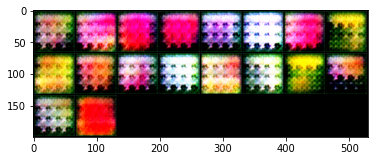

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 1, lossD:1.524965808229539, lossG:3.2480160287283,lossG_fake:1.7628092731086953, lossG_real:1.4852067533048612 ,equality:0.2776025198038341


evaluate:146.31663513183594,kid_mean:0.09643407166004181, kid_std:0.03444109484553337,kid_:(tensor(0.0964), tensor(0.0344))


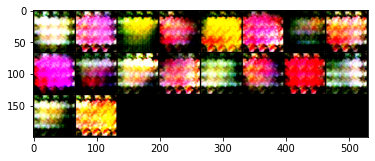

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 2, lossD:1.5878745791981521, lossG:3.164478690878859,lossG_fake:1.7409583469039027, lossG_real:1.4235203590207888 ,equality:0.31743798788311395


evaluate:123.40564727783203,kid_mean:0.07802959531545639, kid_std:0.03460611030459404,kid_:(tensor(0.0780), tensor(0.0346))


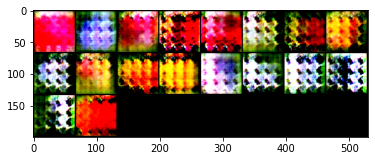

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 3, lossD:1.5602724274385322, lossG:3.158522580433818,lossG_fake:1.7160761321632607, lossG_real:1.4424464494279288 ,equality:0.27362968273533195


evaluate:110.6094741821289,kid_mean:0.06232544779777527, kid_std:0.0353541299700737,kid_:(tensor(0.0623), tensor(0.0354))


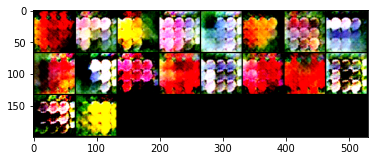

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 4, lossD:1.5975039630260282, lossG:3.128484075509229,lossG_fake:1.6908526895115676, lossG_real:1.4376313848402893 ,equality:0.25322130467127835


evaluate:110.38397979736328,kid_mean:0.06942825019359589, kid_std:0.041874684393405914,kid_:(tensor(0.0694), tensor(0.0419))


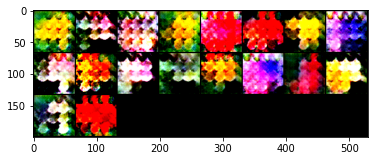

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 5, lossD:1.6087451941758684, lossG:3.0821446377096824,lossG_fake:1.6655157480425047, lossG_real:1.4166288989261515 ,equality:0.24888684911635317


evaluate:125.16631317138672,kid_mean:0.08442510664463043, kid_std:0.04102880880236626,kid_:(tensor(0.0844), tensor(0.0410))


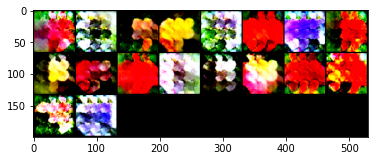

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 6, lossD:1.616228911483172, lossG:3.0288570436459143,lossG_fake:1.6348496953260552, lossG_real:1.3940073529493462 ,equality:0.24084234237670898


evaluate:112.94135284423828,kid_mean:0.07057801634073257, kid_std:0.03682931512594223,kid_:(tensor(0.0706), tensor(0.0368))


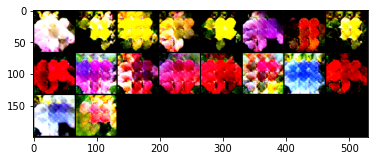

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 7, lossD:1.6389282733491324, lossG:2.99164745182667,lossG_fake:1.6029694253958544, lossG_real:1.3886780055981238 ,equality:0.2142914197977306


evaluate:123.85253143310547,kid_mean:0.07748232036828995, kid_std:0.03851553052663803,kid_:(tensor(0.0775), tensor(0.0385))


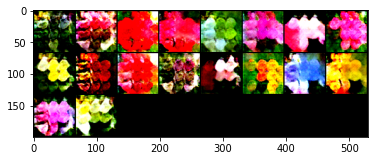

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 8, lossD:1.6378992240405776, lossG:2.9544428644828424,lossG_fake:1.5730462155295808, lossG_real:1.3813966200189682 ,equality:0.19164959551061256


evaluate:120.39655303955078,kid_mean:0.08571424335241318, kid_std:0.045526109635829926,kid_:(tensor(0.0857), tensor(0.0455))


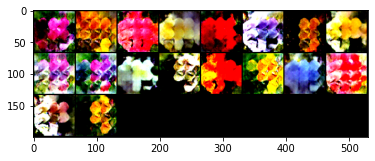

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 9, lossD:1.6100745953402473, lossG:2.994735134458079,lossG_fake:1.601279038827396, lossG_real:1.3934560979454262 ,equality:0.20782294088196984


evaluate:119.39218139648438,kid_mean:0.06652870029211044, kid_std:0.03990672156214714,kid_:(tensor(0.0665), tensor(0.0399))


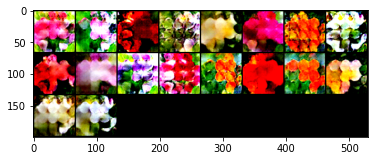

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 10, lossD:1.6158380311669656, lossG:2.986468710945648,lossG_fake:1.5823689456124908, lossG_real:1.404099765911843 ,equality:0.1782691797006477


evaluate:121.38245391845703,kid_mean:0.07712176442146301, kid_std:0.03572296351194382,kid_:(tensor(0.0771), tensor(0.0357))


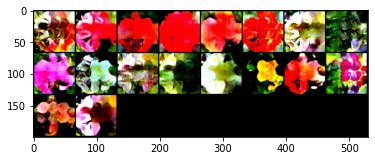

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 11, lossD:1.6211857598962136, lossG:3.0093248376568544,lossG_fake:1.587211134364304, lossG_real:1.4221137056072939 ,equality:0.16509742875701017


evaluate:119.82701873779297,kid_mean:0.07620798051357269, kid_std:0.03675459697842598,kid_:(tensor(0.0762), tensor(0.0368))


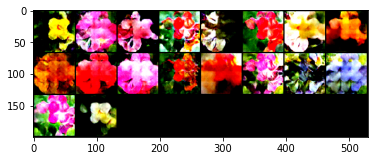

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 12, lossD:1.5881404865135267, lossG:3.0248159459493693,lossG_fake:1.5987334262977526, lossG_real:1.426082518494245 ,equality:0.17265090780350767


evaluate:120.15802001953125,kid_mean:0.07581594586372375, kid_std:0.0430913008749485,kid_:(tensor(0.0758), tensor(0.0431))


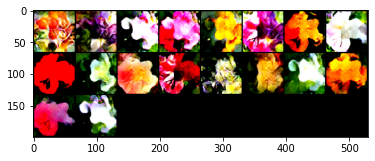

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 13, lossD:1.5881641269887534, lossG:3.029909680190596,lossG_fake:1.5774770107084108, lossG_real:1.452432668903499 ,equality:0.12504434180491186


evaluate:122.3399887084961,kid_mean:0.07847118377685547, kid_std:0.04017423465847969,kid_:(tensor(0.0785), tensor(0.0402))


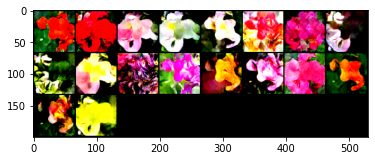

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 14, lossD:1.5939675314912518, lossG:3.0169690558053914,lossG_fake:1.5765860051784701, lossG_real:1.4403830494695498 ,equality:0.13620295570892038


evaluate:119.1934585571289,kid_mean:0.08015884459018707, kid_std:0.04028314724564552,kid_:(tensor(0.0802), tensor(0.0403))


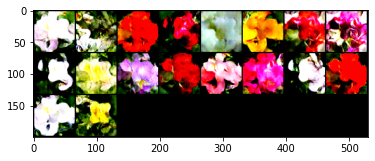

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 15, lossD:1.5847746342131235, lossG:3.0342423684388686,lossG_fake:1.581239203226219, lossG_real:1.4530031559536758 ,equality:0.12823604727254323


evaluate:123.72454833984375,kid_mean:0.0854606032371521, kid_std:0.04687829688191414,kid_:(tensor(0.0855), tensor(0.0469))


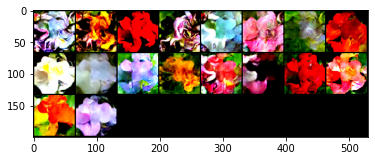

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 16, lossD:1.5654275347885576, lossG:3.0994716523920447,lossG_fake:1.6070925448704692, lossG_real:1.4923791202526648 ,equality:0.11471342461780432


evaluate:121.70096588134766,kid_mean:0.07765902578830719, kid_std:0.039710789918899536,kid_:(tensor(0.0777), tensor(0.0397))


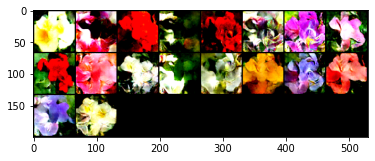

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 17, lossD:1.567973315137104, lossG:3.084762665831927,lossG_fake:1.5975664356379833, lossG_real:1.4871962394529177 ,equality:0.1103701961850656


evaluate:120.92363739013672,kid_mean:0.07901069521903992, kid_std:0.042268864810466766,kid_:(tensor(0.0790), tensor(0.0423))


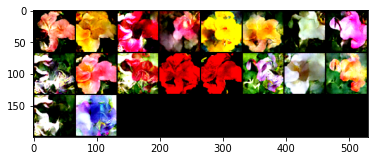

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 18, lossD:1.5448725825374565, lossG:3.189407480573191,lossG_fake:1.6453347657490702, lossG_real:1.5440727258191524 ,equality:0.10126203992991778


evaluate:119.99198913574219,kid_mean:0.0799250677227974, kid_std:0.0470275953412056,kid_:(tensor(0.0799), tensor(0.0470))


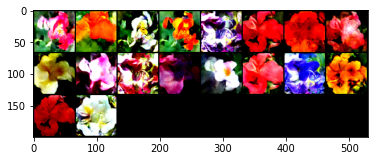

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 19, lossD:1.5320794848562445, lossG:3.2079679410434463,lossG_fake:1.658696269526065, lossG_real:1.5492716692026378 ,equality:0.10942460032342716


evaluate:118.20675659179688,kid_mean:0.07860492169857025, kid_std:0.04473542794585228,kid_:(tensor(0.0786), tensor(0.0447))


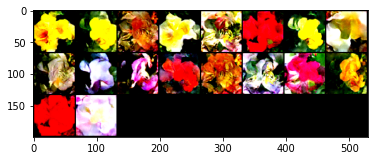

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 20, lossD:1.4803148027762627, lossG:3.3836869244436616,lossG_fake:1.7519830638922533, lossG_real:1.6317038646022093 ,equality:0.12027919929004405


evaluate:118.65937805175781,kid_mean:0.07243771851062775, kid_std:0.03918281942605972,kid_:(tensor(0.0724), tensor(0.0392))


100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 21, lossD:1.4908242341384148, lossG:3.2819641469751746,lossG_fake:1.6918603280215587, lossG_real:1.5901038021717258 ,equality:0.10175652584983297


evaluate:118.24685668945312,kid_mean:0.0818084329366684, kid_std:0.04221136495471001,kid_:(tensor(0.0818), tensor(0.0422))


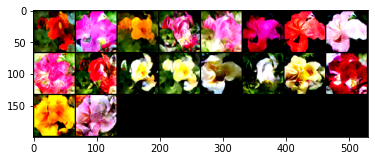

100%|██████████| 103/103 [00:59<00:00,  1.75it/s]


epoch: 22, lossD:1.4957367343809997, lossG:3.307036263271443,lossG_fake:1.692763347070194, lossG_real:1.614272924302851 ,equality:0.07849042276734286


evaluate:118.42219543457031,kid_mean:0.08023201674222946, kid_std:0.04474712163209915,kid_:(tensor(0.0802), tensor(0.0447))


100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 23, lossD:1.464612229356488, lossG:3.356926709702871,lossG_fake:1.7141727266959774, lossG_real:1.642753987057695 ,equality:0.07141873963828238


evaluate:118.55255889892578,kid_mean:0.08297235518693924, kid_std:0.04817876219749451,kid_:(tensor(0.0830), tensor(0.0482))


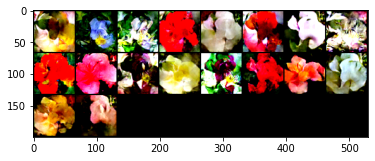

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 24, lossD:1.454890850678231, lossG:3.416204450199905,lossG_fake:1.7284321634514819, lossG_real:1.6877722902205383 ,equality:0.040659873230943555


evaluate:120.90840911865234,kid_mean:0.07435117661952972, kid_std:0.039574023336172104,kid_:(tensor(0.0744), tensor(0.0396))


100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 25, lossD:1.4472521832845744, lossG:3.408371987852078,lossG_fake:1.7388381361961365, lossG_real:1.6695338533919992 ,equality:0.06930428280413725


evaluate:122.44847869873047,kid_mean:0.08294923603534698, kid_std:0.0448572114109993,kid_:(tensor(0.0829), tensor(0.0449))


100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 26, lossD:1.4283561787558992, lossG:3.494348259805476,lossG_fake:1.7821526533191643, lossG_real:1.712195598384709 ,equality:0.06995705493445525


evaluate:124.08929443359375,kid_mean:0.0783366709947586, kid_std:0.04614216089248657,kid_:(tensor(0.0783), tensor(0.0461))


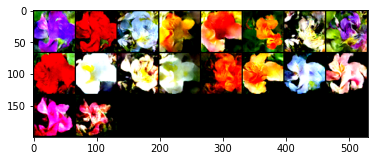

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 27, lossD:1.43007692202781, lossG:3.475876072078075,lossG_fake:1.764277849961253, lossG_real:1.7115982377413408 ,equality:0.05267961221991224


evaluate:122.58635711669922,kid_mean:0.07354885339736938, kid_std:0.035755034536123276,kid_:(tensor(0.0735), tensor(0.0358))


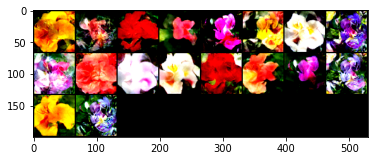

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 28, lossD:1.395018084535321, lossG:3.5531501492250315,lossG_fake:1.802283417831347, lossG_real:1.7508667394952866 ,equality:0.05141667833606034


evaluate:123.69343566894531,kid_mean:0.07288677990436554, kid_std:0.03952203318476677,kid_:(tensor(0.0729), tensor(0.0395))


100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 29, lossD:1.3782583654505536, lossG:3.628484019955385,lossG_fake:1.8378626588478828, lossG_real:1.790621370945162 ,equality:0.04724128790272086


evaluate:124.70738220214844,kid_mean:0.08047077804803848, kid_std:0.040893878787755966,kid_:(tensor(0.0805), tensor(0.0409))


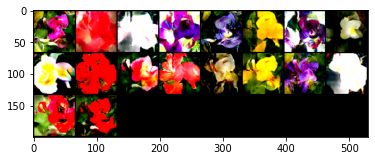

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 30, lossD:1.3653880091546808, lossG:3.6756257432178385,lossG_fake:1.8452379304228477, lossG_real:1.8303878087441898 ,equality:0.014850121678657846


evaluate:124.66814422607422,kid_mean:0.07706314325332642, kid_std:0.040913697332143784,kid_:(tensor(0.0771), tensor(0.0409))


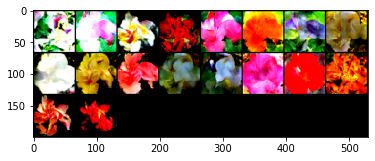

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 31, lossD:1.3453696225453349, lossG:3.7432519695133837,lossG_fake:1.881847494435542, lossG_real:1.8614044652401822 ,equality:0.020443029195359674


evaluate:123.15435028076172,kid_mean:0.08385362476110458, kid_std:0.045874327421188354,kid_:(tensor(0.0839), tensor(0.0459))


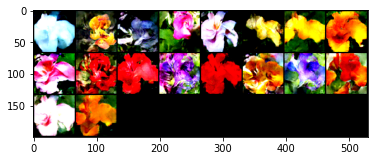

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 32, lossD:1.3370037281397478, lossG:3.856551193496556,lossG_fake:1.9244167509588224, lossG_real:1.932134432121388 ,equality:-0.007717681162565659


evaluate:124.59574890136719,kid_mean:0.08231878280639648, kid_std:0.04271037131547928,kid_:(tensor(0.0823), tensor(0.0427))


100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 33, lossD:1.3010125038693252, lossG:3.790122217345006,lossG_fake:1.8925160910319356, lossG_real:1.897606120526212 ,equality:-0.0050900294942763935


evaluate:124.30392456054688,kid_mean:0.08139272779226303, kid_std:0.03981552645564079,kid_:(tensor(0.0814), tensor(0.0398))


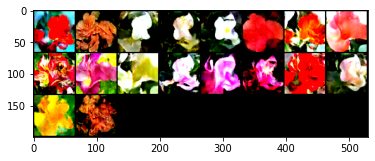

100%|██████████| 103/103 [00:59<00:00,  1.75it/s]


epoch: 34, lossD:1.2599441501700763, lossG:3.975452816602096,lossG_fake:1.9802638882572212, lossG_real:1.9951889376038487 ,equality:-0.014925049346627528


evaluate:126.46321868896484,kid_mean:0.08726020902395248, kid_std:0.04223759099841118,kid_:(tensor(0.0873), tensor(0.0422))


100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 35, lossD:1.2806691347974017, lossG:3.978487468460231,lossG_fake:1.990541214503131, lossG_real:1.9879462533784145 ,equality:0.002594961124716466


evaluate:128.25552368164062,kid_mean:0.08876027911901474, kid_std:0.03988907113671303,kid_:(tensor(0.0888), tensor(0.0399))


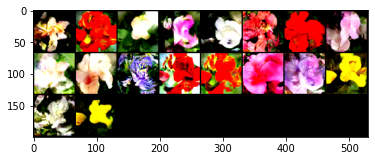

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 36, lossD:1.2493364533174385, lossG:3.8788346156333255,lossG_fake:1.9515796436846835, lossG_real:1.9272549488012074 ,equality:0.024324694883476106


evaluate:127.14595031738281,kid_mean:0.08201411366462708, kid_std:0.04275702312588692,kid_:(tensor(0.0820), tensor(0.0428))


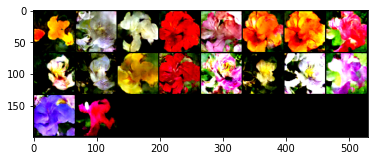

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 37, lossD:1.2384229962108204, lossG:4.100721599986252,lossG_fake:2.03771867103947, lossG_real:2.0630029127435776 ,equality:-0.02528424170410748


evaluate:128.17431640625,kid_mean:0.08982955664396286, kid_std:0.046262260526418686,kid_:(tensor(0.0898), tensor(0.0463))


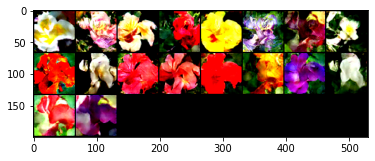

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 38, lossD:1.2232923704443626, lossG:4.10129029542497,lossG_fake:2.0449520650419215, lossG_real:2.056338221124075 ,equality:-0.01138615608215332


evaluate:130.12481689453125,kid_mean:0.08904695510864258, kid_std:0.04739151895046234,kid_:(tensor(0.0890), tensor(0.0474))


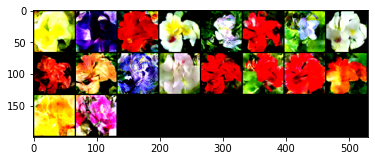

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 39, lossD:1.1885569072464137, lossG:4.166263295608816,lossG_fake:2.0550359776876506, lossG_real:2.1112273121343077 ,equality:-0.05619133444665714


evaluate:130.00262451171875,kid_mean:0.09048009663820267, kid_std:0.044610146433115005,kid_:(tensor(0.0905), tensor(0.0446))


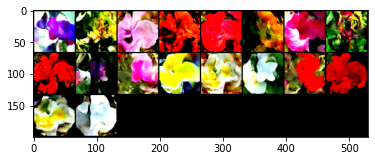

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 40, lossD:1.1867648392047696, lossG:4.236670885271239,lossG_fake:2.1104200117796372, lossG_real:2.1262508798571464 ,equality:-0.01583086807750922


evaluate:129.71240234375,kid_mean:0.08698131889104843, kid_std:0.044701527804136276,kid_:(tensor(0.0870), tensor(0.0447))


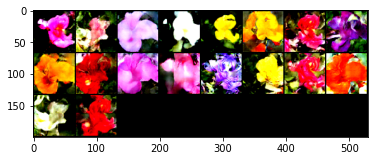

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 41, lossD:1.1670425580543222, lossG:4.194290054654612,lossG_fake:2.0866631362044696, lossG_real:2.1076269057190533 ,equality:-0.020963769514583674


evaluate:130.92071533203125,kid_mean:0.09425642341375351, kid_std:0.0514092817902565,kid_:(tensor(0.0943), tensor(0.0514))


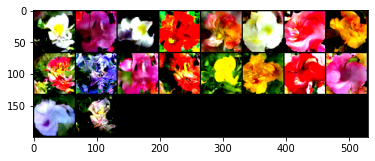

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 42, lossD:1.138209460429775, lossG:4.30245968670521,lossG_fake:2.1213034507140374, lossG_real:2.181156215158481 ,equality:-0.05985276444444354


evaluate:130.98329162597656,kid_mean:0.08779194951057434, kid_std:0.04632991924881935,kid_:(tensor(0.0878), tensor(0.0463))


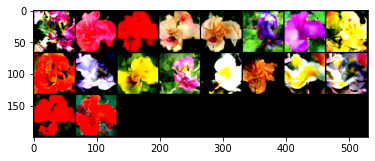

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 43, lossD:1.0818810144674431, lossG:4.576119096533766,lossG_fake:2.2456446284229314, lossG_real:2.3304744912582693 ,equality:-0.08482986283533789


evaluate:130.65798950195312,kid_mean:0.08468791842460632, kid_std:0.03956280276179314,kid_:(tensor(0.0847), tensor(0.0396))


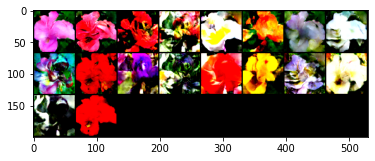

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 44, lossD:1.1087428030458468, lossG:4.529422438260421,lossG_fake:2.2365485105699707, lossG_real:2.29287392074622 ,equality:-0.05632541017624915


evaluate:130.37367248535156,kid_mean:0.09066975861787796, kid_std:0.04588327184319496,kid_:(tensor(0.0907), tensor(0.0459))


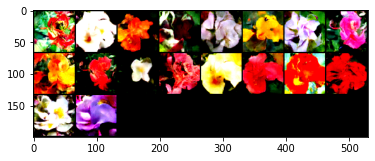

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 45, lossD:1.0784325223524593, lossG:4.669871612659936,lossG_fake:2.29449634181643, lossG_real:2.3753752534829298 ,equality:-0.08087891166649985


evaluate:130.2994384765625,kid_mean:0.09039096534252167, kid_std:0.049138233065605164,kid_:(tensor(0.0904), tensor(0.0491))


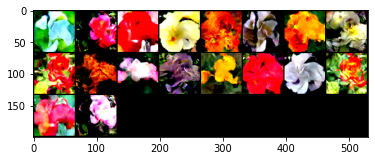

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 46, lossD:1.021620814372035, lossG:4.744403788186972,lossG_fake:2.321765945953073, lossG_real:2.4226378254520085 ,equality:-0.10087187949893561


evaluate:130.416015625,kid_mean:0.08533628284931183, kid_std:0.039946310222148895,kid_:(tensor(0.0853), tensor(0.0399))


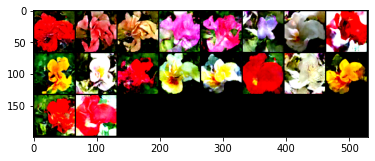

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 47, lossD:1.0239001929181293, lossG:4.724319698741135,lossG_fake:2.3209459469156357, lossG_real:2.4033737518254994 ,equality:-0.08242780490986368


evaluate:129.75694274902344,kid_mean:0.08753194659948349, kid_std:0.04573680832982063,kid_:(tensor(0.0875), tensor(0.0457))


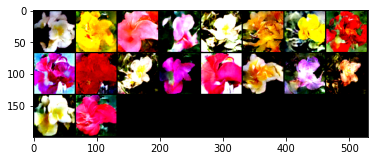

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 48, lossD:0.9928308846881089, lossG:4.8894773362909705,lossG_fake:2.383524004695485, lossG_real:2.505953333910229 ,equality:-0.12242932921474425


evaluate:128.48492431640625,kid_mean:0.0890972912311554, kid_std:0.04061928018927574,kid_:(tensor(0.0891), tensor(0.0406))


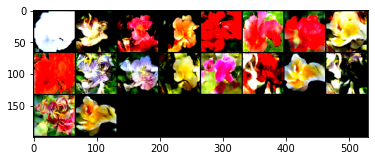

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 49, lossD:0.9606560549689728, lossG:4.991813196719272,lossG_fake:2.421223742290608, lossG_real:2.5705894451696896 ,equality:-0.14936570287908157


evaluate:129.40994262695312,kid_mean:0.08559213578701019, kid_std:0.045907143503427505,kid_:(tensor(0.0856), tensor(0.0459))


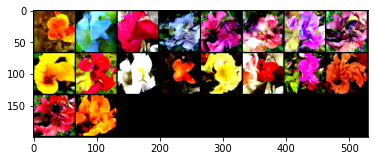

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 50, lossD:0.9932352677711005, lossG:4.923769904571829,lossG_fake:2.4029136433184726, lossG_real:2.5208562334764353 ,equality:-0.11794259015796271


evaluate:128.80865478515625,kid_mean:0.08355623483657837, kid_std:0.046692121773958206,kid_:(tensor(0.0836), tensor(0.0467))


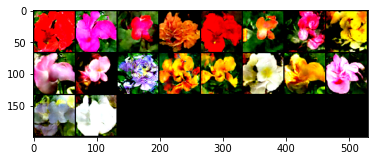

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 51, lossD:0.9735022482362766, lossG:5.008838348018313,lossG_fake:2.4356411464005996, lossG_real:2.5731971946734826 ,equality:-0.13755604827288304


evaluate:129.16937255859375,kid_mean:0.07227585464715958, kid_std:0.04332040250301361,kid_:(tensor(0.0723), tensor(0.0433))


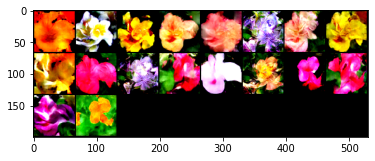

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 52, lossD:0.9572545388369884, lossG:5.148989219109989,lossG_fake:2.4765653552360907, lossG_real:2.6724238424625213 ,equality:-0.19585848722643062


evaluate:129.61248779296875,kid_mean:0.087155282497406, kid_std:0.03812480345368385,kid_:(tensor(0.0872), tensor(0.0381))


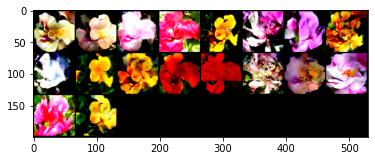

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 53, lossD:0.9394576702881785, lossG:5.233647723799771,lossG_fake:2.505222626102781, lossG_real:2.72842510464122 ,equality:-0.22320247853843878


evaluate:130.04380798339844,kid_mean:0.09019399434328079, kid_std:0.04441602900624275,kid_:(tensor(0.0902), tensor(0.0444))


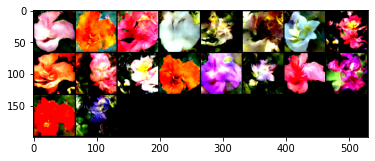

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 54, lossD:0.872023664053204, lossG:5.420782698010935,lossG_fake:2.630671018535651, lossG_real:2.790111694521117 ,equality:-0.15944067598546585


evaluate:129.35580444335938,kid_mean:0.08423607051372528, kid_std:0.041047435253858566,kid_:(tensor(0.0842), tensor(0.0410))


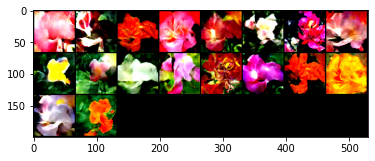

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 55, lossD:0.8819259484705416, lossG:5.40677048859087,lossG_fake:2.616384518956675, lossG_real:2.7903859592178493 ,equality:-0.17400144026117426


evaluate:128.85533142089844,kid_mean:0.08206219971179962, kid_std:0.03726540878415108,kid_:(tensor(0.0821), tensor(0.0373))


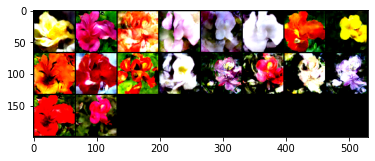

100%|██████████| 103/103 [00:59<00:00,  1.75it/s]


epoch: 56, lossD:0.8083223856768562, lossG:5.575613697755684,lossG_fake:2.659021258354187, lossG_real:2.9165924324572665 ,equality:-0.2575711741030795


evaluate:130.15103149414062,kid_mean:0.08382762968540192, kid_std:0.04372810199856758,kid_:(tensor(0.0838), tensor(0.0437))


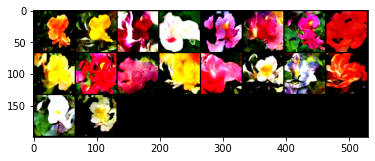

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 57, lossD:0.8788845021169163, lossG:5.343708427206984,lossG_fake:2.543700703139444, lossG_real:2.800007736798629 ,equality:-0.2563070336591853


evaluate:129.49656677246094,kid_mean:0.08890948444604874, kid_std:0.04152372106909752,kid_:(tensor(0.0889), tensor(0.0415))


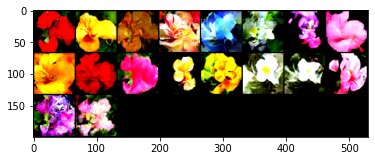

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 58, lossD:0.8612909588998962, lossG:5.531100414331677,lossG_fake:2.638423962500489, lossG_real:2.8926764553033033 ,equality:-0.25425249280281426


evaluate:129.52984619140625,kid_mean:0.09316205978393555, kid_std:0.04414687678217888,kid_:(tensor(0.0932), tensor(0.0441))


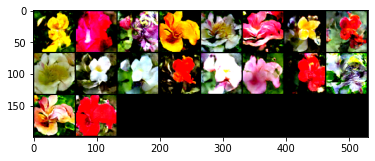

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 59, lossD:0.8735679249161655, lossG:5.459114111742927,lossG_fake:2.645264081584597, lossG_real:2.813850042889419 ,equality:-0.16858596130482217


evaluate:129.38490295410156,kid_mean:0.08671461045742035, kid_std:0.04721856489777565,kid_:(tensor(0.0867), tensor(0.0472))


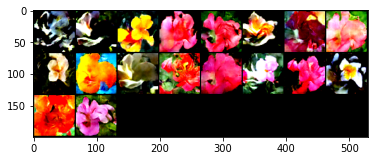

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 60, lossD:0.8597487457168912, lossG:5.6599018504318686,lossG_fake:2.7448776103917836, lossG_real:2.915024212263163 ,equality:-0.1701466018713793


evaluate:128.6760711669922,kid_mean:0.09175784140825272, kid_std:0.0463903583586216,kid_:(tensor(0.0918), tensor(0.0464))


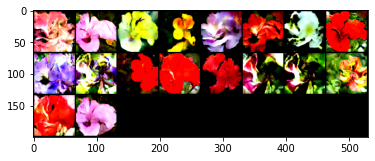

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 61, lossD:0.7665140231691517, lossG:5.728476862305576,lossG_fake:2.7191986273793343, lossG_real:3.0092782546015617 ,equality:-0.29007962722222747


evaluate:129.3387908935547,kid_mean:0.08610397577285767, kid_std:0.04350898787379265,kid_:(tensor(0.0861), tensor(0.0435))


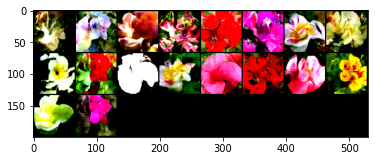

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 62, lossD:0.7443198620983698, lossG:5.974226058108135,lossG_fake:2.8800414997397117, lossG_real:3.0941845531602508 ,equality:-0.21414305342053908


evaluate:128.61651611328125,kid_mean:0.08413438498973846, kid_std:0.03875100985169411,kid_:(tensor(0.0841), tensor(0.0388))


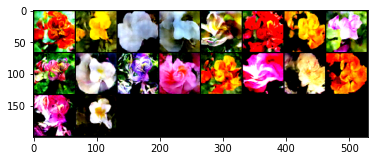

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 63, lossD:0.7112408626137428, lossG:6.109693420743479,lossG_fake:2.8687801314789114, lossG_real:3.24091329736617 ,equality:-0.3721331658872584


evaluate:129.54757690429688,kid_mean:0.08351458609104156, kid_std:0.042602524161338806,kid_:(tensor(0.0835), tensor(0.0426))


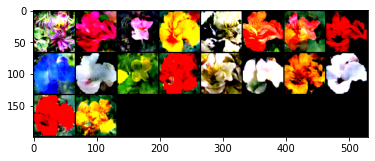

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 64, lossD:0.7166647118272134, lossG:6.121252981204431,lossG_fake:2.895709359530106, lossG_real:3.225543607785864 ,equality:-0.3298342482557577


evaluate:129.17276000976562,kid_mean:0.08574533462524414, kid_std:0.03861836716532707,kid_:(tensor(0.0857), tensor(0.0386))


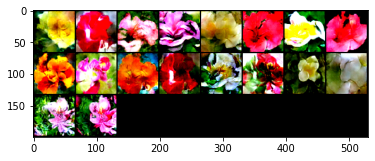

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 65, lossD:0.7482335103078953, lossG:6.094235721143704,lossG_fake:2.8595762669461444, lossG_real:3.234659433364868 ,equality:-0.37508316641872375


evaluate:128.23695373535156,kid_mean:0.08383781462907791, kid_std:0.04594850912690163,kid_:(tensor(0.0838), tensor(0.0459))


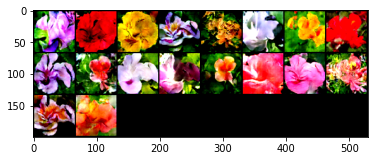

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 66, lossD:0.7122881790098635, lossG:6.3823567871908535,lossG_fake:3.001239446760381, lossG_real:3.38111732538464 ,equality:-0.3798778786242587


evaluate:128.27651977539062,kid_mean:0.07852782309055328, kid_std:0.042832501232624054,kid_:(tensor(0.0785), tensor(0.0428))


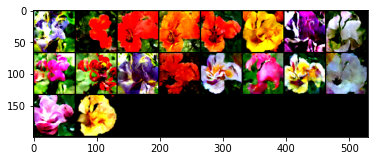

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 67, lossD:0.7046842800760732, lossG:5.873299918128449,lossG_fake:2.8013139245579546, lossG_real:3.071985981996777 ,equality:-0.2706720574388224


evaluate:128.47535705566406,kid_mean:0.08087028563022614, kid_std:0.0493377186357975,kid_:(tensor(0.0809), tensor(0.0493))


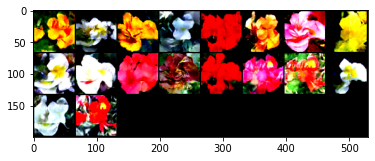

100%|██████████| 103/103 [00:59<00:00,  1.74it/s]


epoch: 68, lossD:0.6627118008084667, lossG:6.266312742696225,lossG_fake:2.9528998645763953, lossG_real:3.3134128642313687 ,equality:-0.3605129996549734


evaluate:128.63172912597656,kid_mean:0.08799853175878525, kid_std:0.044607631862163544,kid_:(tensor(0.0880), tensor(0.0446))


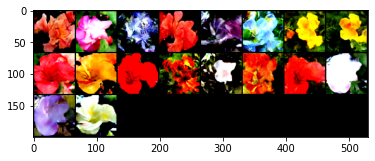

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 69, lossD:0.6594773065841314, lossG:6.307181714807899,lossG_fake:2.965126754010765, lossG_real:3.342054957325019 ,equality:-0.3769282033142538


evaluate:128.4503173828125,kid_mean:0.08414790779352188, kid_std:0.038730498403310776,kid_:(tensor(0.0841), tensor(0.0387))


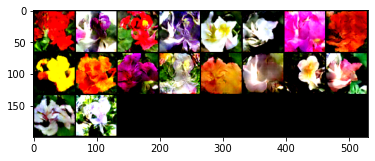

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 70, lossD:0.6614828911221143, lossG:6.3698642786266735,lossG_fake:3.012440540258167, lossG_real:3.357423722165302 ,equality:-0.3449831819071352


evaluate:128.64166259765625,kid_mean:0.08059301972389221, kid_std:0.04107215628027916,kid_:(tensor(0.0806), tensor(0.0411))


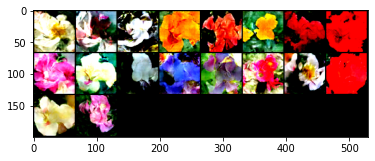

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 71, lossD:0.6981031333358543, lossG:6.158673355880293,lossG_fake:2.890800099928402, lossG_real:3.267873254794519 ,equality:-0.37707315486611703


evaluate:128.52906799316406,kid_mean:0.08225004374980927, kid_std:0.03880006819963455,kid_:(tensor(0.0823), tensor(0.0388))


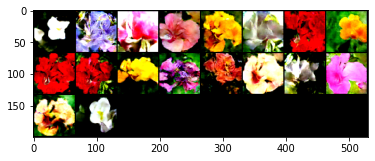

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 72, lossD:0.7587759763508746, lossG:6.112216930944943,lossG_fake:2.8856982363080514, lossG_real:3.2265186876926606 ,equality:-0.34082045138460915


evaluate:128.38075256347656,kid_mean:0.08101106435060501, kid_std:0.041814833879470825,kid_:(tensor(0.0810), tensor(0.0418))


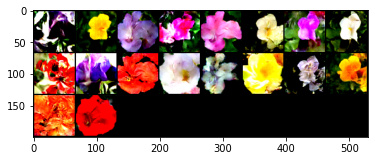

100%|██████████| 103/103 [00:59<00:00,  1.73it/s]


epoch: 73, lossD:0.6309679607743198, lossG:6.367444755961594,lossG_fake:2.95907217322044, lossG_real:3.408372588528013 ,equality:-0.4493004153075728


evaluate:128.58255004882812,kid_mean:0.09077434241771698, kid_std:0.04567151144146919,kid_:(tensor(0.0908), tensor(0.0457))


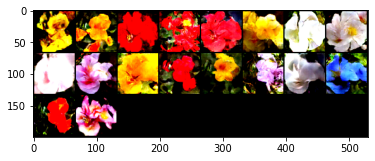

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 74, lossD:0.6525494420123332, lossG:6.541629823666175,lossG_fake:3.072705779260802, lossG_real:3.468924037461142 ,equality:-0.39621825820033996


evaluate:128.15916442871094,kid_mean:0.08626199513673782, kid_std:0.048276614397764206,kid_:(tensor(0.0863), tensor(0.0483))


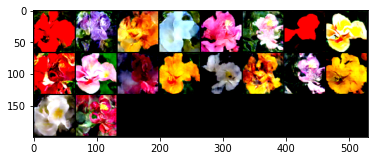

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

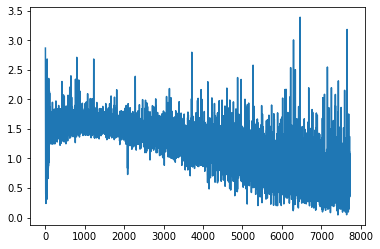

In [45]:
plt.plot(raw_lossesD)

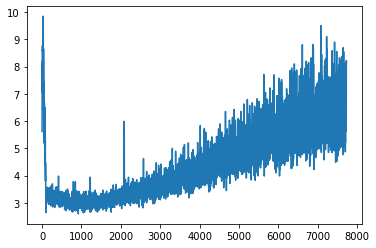

In [46]:
plt.plot(raw_lossesG)

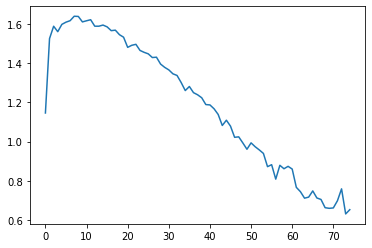

In [47]:
plt.plot(lossesD)

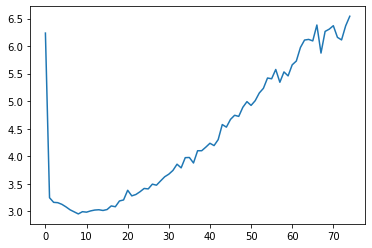

In [48]:
plt.plot(lossesG)

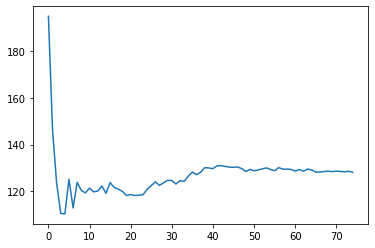

In [49]:
plt.plot(fid_)

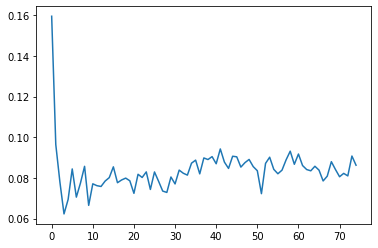

In [50]:
plt.plot(kid_mean_)

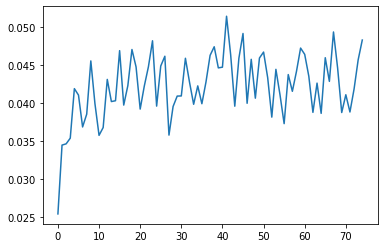

In [51]:
plt.plot(kid_std_)

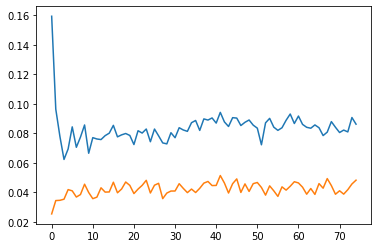

In [52]:
plt.plot(kid_score)

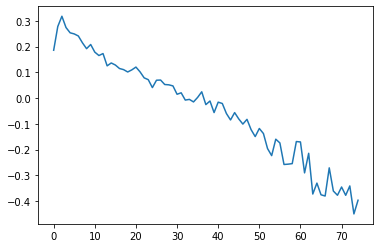

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0840), tensor(0.0492))